In [1]:
import numpy as np
import specutils
import time
import astropy.modeling.fitting as fitting
from astropy.table import Table, QTable
from astropy.nddata import StdDevUncertainty
import astropy.units as u
from astropy.visualization import quantity_support

In [2]:
# import astropy
# import matplotlib
# print("Astropy Version: ",astropy.__version__)
# print("Numpy Version: ",np.__version__)
# print("Specutils Version: ",specutils.__version__)
# print("Matplotlib Version: ",matplotlib.__version__)

In [3]:
import matplotlib.pyplot as plt
# inline -- noninteractive cells, notebook -- interactive cells 
%matplotlib inline 
# %matplotlib notebook
%config InlineBackend.figure_format ='retina' # Mackbook optimization

In [4]:
datafile = "./n5548_mean_g130mb4.ecsv"
regionsfile = "./n5548_lyalpha_sample.dat"

In [5]:
data = QTable.read(datafile, format='ascii.ecsv')
data[:3]

wavelength,flux,uncertainty
Angstrom,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s)
float64,float64,float64
1139.99559,4.39553486807e-14,1.12651909249e-15
1140.03439,4.15510398254e-14,1.09891679648e-15
1140.07320,4.31114724961e-14,1.12382203631e-15


In [6]:
uncertainty = StdDevUncertainty(data['uncertainty'])
spectrum = specutils.Spectrum1D(spectral_axis=data['wavelength'],
                                flux=data['flux'], uncertainty=uncertainty)
print(spectrum)

Spectrum1D (length=6058)
flux:             [ 4.3955e-14 erg / (Angstrom cm2 s), ..., 4.2905e-14 erg / (Angstrom cm2 s) ],  mean=6.9511e-14 erg / (Angstrom cm2 s)
spectral axis:    [ 1140.0 Angstrom, ..., 1375.0 Angstrom ],  mean=1257.5 Angstrom
uncertainty:      [ StdDevUncertainty(1.12651909e-15), ..., StdDevUncertainty(6.8110986e-16) ]


In [7]:
regionstab = QTable.read(regionsfile,format='ascii')
subregions = []
for x0,x1 in zip(regionstab['col1'],regionstab['col2']):
    subregions += [(x0*u.AA, x1*u.AA)]
regions=specutils.SpectralRegion(subregions)
regions

Spectral Region, 24 sub-regions:
  (1145.83 Angstrom, 1151.33 Angstrom) 
  (1152.88 Angstrom, 1187.88 Angstrom) 
  (1193.68 Angstrom, 1197.7 Angstrom)  
  (1197.3 Angstrom, 1198.53 Angstrom)  
  (1201.38 Angstrom, 1205.38 Angstrom) 
  (1207.08 Angstrom, 1208.36 Angstrom) 
  (1210.58 Angstrom, 1213.58 Angstrom) 
  (1217.38 Angstrom, 1218.75 Angstrom) 
  (1220.3 Angstrom, 1221.7 Angstrom)   
  (1223.02 Angstrom, 1224.08 Angstrom) 
  (1225.74 Angstrom, 1227.2 Angstrom)  
  (1227.86 Angstrom, 1228.35 Angstrom) 
  (1229.08 Angstrom, 1230.38 Angstrom) 
  (1236.68 Angstrom, 1238.0 Angstrom)  
  (1238.95 Angstrom, 1239.53 Angstrom) 
  (1240.42 Angstrom, 1242.24 Angstrom) 
  (1242.93 Angstrom, 1249.88 Angstrom) 
  (1250.68 Angstrom, 1253.17 Angstrom) 
  (1254.04 Angstrom, 1254.32 Angstrom) 
  (1256.36 Angstrom, 1256.47 Angstrom) 
  (1263.37 Angstrom, 1263.64 Angstrom) 
  (1264.28 Angstrom, 1270.0 Angstrom)  
  (1362.51 Angstrom, 1369.56 Angstrom) 
  (1370.15 Angstrom, 1372.76 Angstrom) 

In [8]:
def mask_from_regions(spectrum,regions):
    mask = np.zeros(spectrum.spectral_axis.shape,dtype=np.bool)
    for r in regions:
        submask = (spectrum.spectral_axis>r.lower) & (spectrum.spectral_axis<=r.upper)
        mask = mask | submask
    spectrum.mask = mask

In [9]:
mask_from_regions(spectrum,regions)
print(spectrum.mask.min(), spectrum.mask.max())

False True


/var/folders/z6/bz261yzj6xgdy20gz4lpfn4r00018h/T/ipykernel_1841/3955972367.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(spectrum.spectral_axis.shape,dtype=np.bool)


In [10]:
def plot_spectrum(spectrum,color='b',alpha=0.5,figsize=(15,6),
                  label=None,ax=None,plot_mask=True,
                  mask_color='g',mask_alpha=0.1,title=None):
    with quantity_support():
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        ax.plot(spectrum.spectral_axis,spectrum.flux,color=color,alpha=alpha,label=label)
        if plot_mask: 
            if spectrum.mask is not None:
                ax.fill_between(spectrum.spectral_axis,0,spectrum.flux*spectrum.mask,
                        alpha=mask_alpha,color=mask_color)
    ax.set_xlabel(r"Wavelength (" + ax.get_xlabel() + ")")
    ax.set_ylabel(r"Flux (" + ax.get_ylabel() + ")")
    return ax

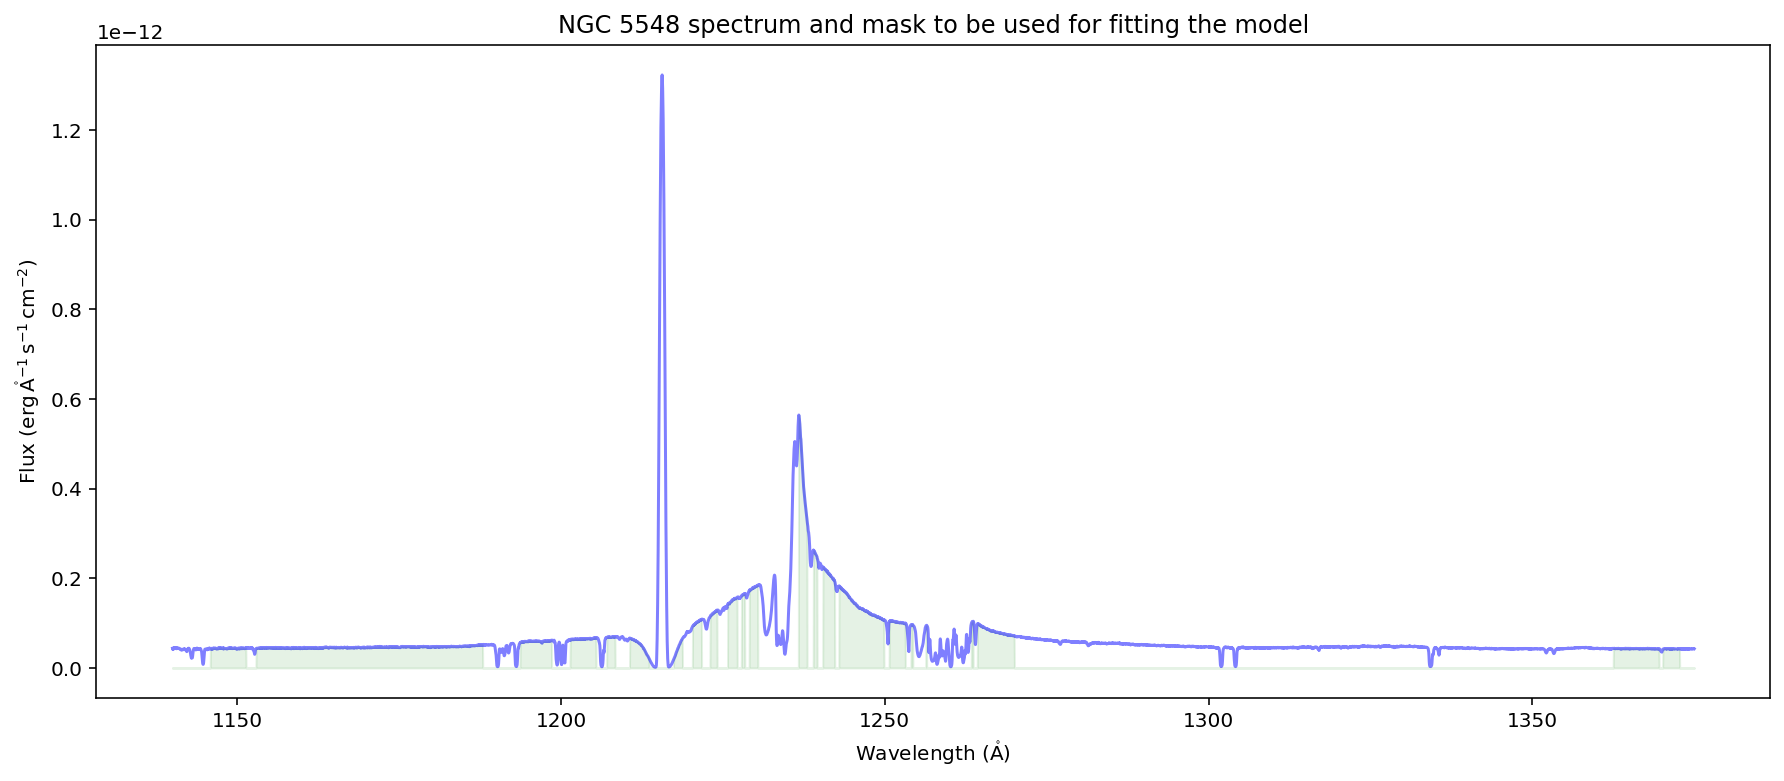

In [11]:
ax = plot_spectrum(spectrum)
ax.set_title('NGC 5548 spectrum and mask to be used for fitting the model');

In [12]:
import n5548_models as models

In [13]:
compound_model = models.model1

In [14]:
print(compound_model)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] * [1] + [2] + [3] + [4] + [5] + [6] + [7] + [8] + [9] + [10] + [11] + [12] + [13] + [14] + [15] + [16] + [17] + [18] + [19] + [20] + [21]
Components: 
    [0]: <powerlaw(amplitude=0., x_0=1000., alpha=0.4819233, name='powerlaw1')>

    [1]: <ccmext(ebmv=0.01713, rv=3.1, name='extinction')>

    [2]: <gaussian(norm=0., mean=1195.006, fwhm=861.4926, skew=1., name='C III 1176')>

    [3]: <gaussian(norm=0., mean=1226.392, fwhm=861.4926, skew=1., name='Si III 1206')>

    [4]: <gaussian(norm=0., mean=1236.729, fwhm=255.4998, skew=1., name='Ly alpha - NLR, ILR,  medium,  very broad')>

    [5]: <gaussian(norm=0., mean=1235.996, fwhm=861.4926, skew=1., name='gaussian5')>

    [6]: <gaussian(norm=0., mean=1235.138, fwhm=3040.59, skew=1., name='gaussian6')>

    [7]: <gaussian(norm=0., mean=1231.589, fwhm=8133.099, skew=1., name='gaussian7')>

    [8]: <gaussian(norm=0., mean=1237.643, fwhm=18183.71, skew=1.,

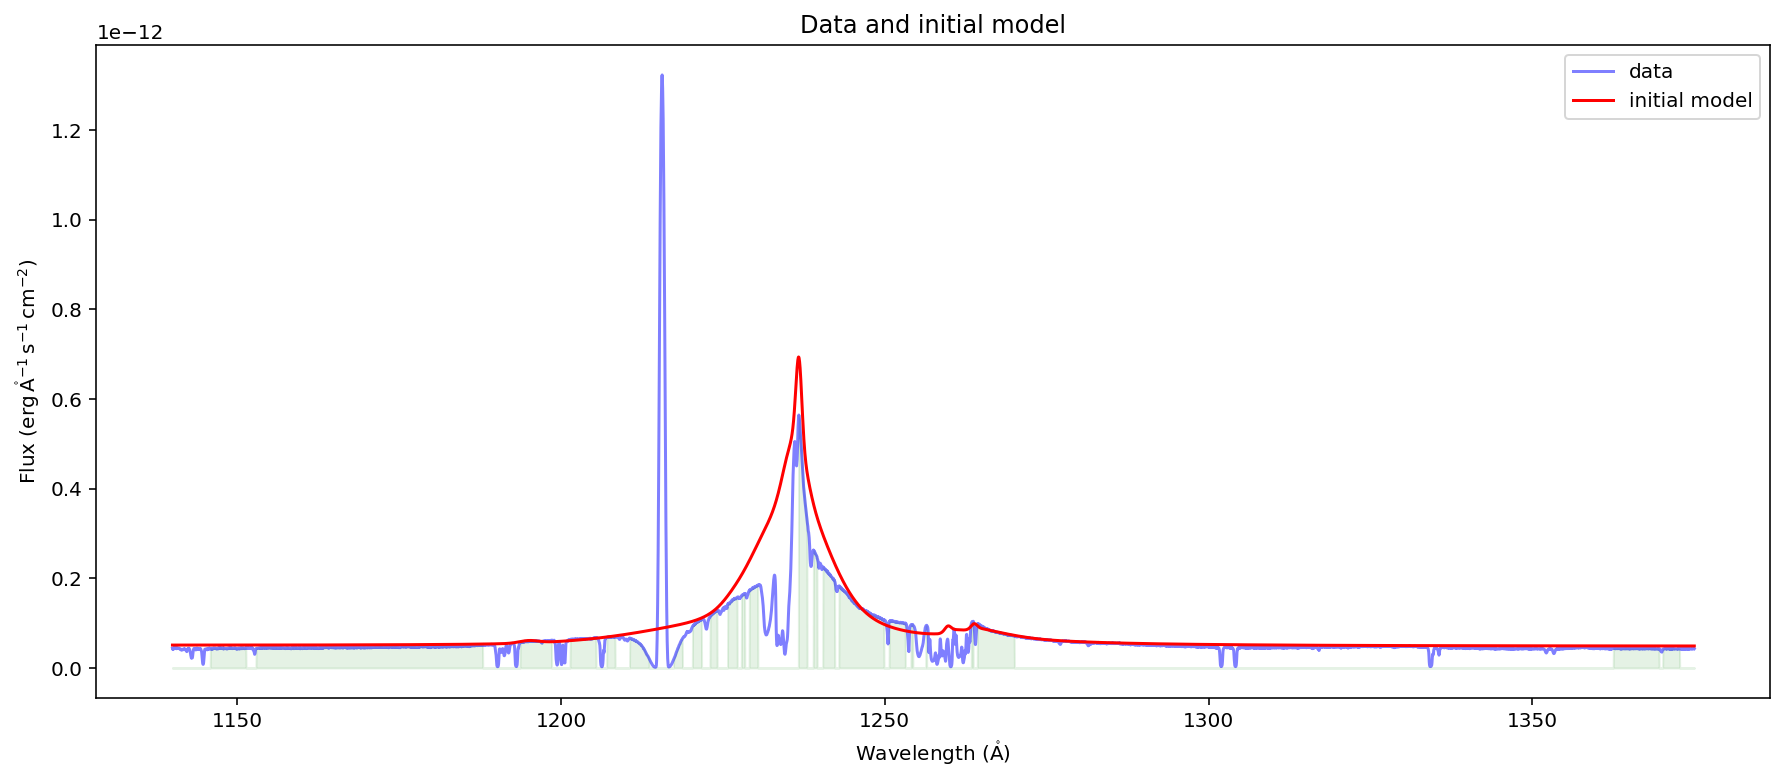

In [15]:
ax = plot_spectrum(spectrum,label='data')
ax.plot(spectrum.spectral_axis, compound_model(spectrum.spectral_axis.value), 'r',label='initial model')
ax.legend()
ax.set_title("Data and initial model");

In [16]:
fitter = fitting.LevMarLSQFitter()

In [17]:
wavelength = spectrum.spectral_axis.value
flux = spectrum.flux.value
inverse_sigma = spectrum.mask/spectrum.uncertainty.array

In [18]:
start_time = time.time()
fit_result = fitter(compound_model, wavelength, flux, weights=inverse_sigma, acc=1.E-30, maxiter=6000)
end_time = time.time()
print("Elapsed time: ", end_time - start_time)

Elapsed time:  6.378159999847412


In [19]:
print(fitter.fit_info['message'])

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


In [20]:
print(fit_result)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] * [1] + [2] + [3] + [4] + [5] + [6] + [7] + [8] + [9] + [10] + [11] + [12] + [13] + [14] + [15] + [16] + [17] + [18] + [19] + [20] + [21]
Components: 
    [0]: <powerlaw(amplitude=0., x_0=1000., alpha=1.54475946, name='powerlaw1')>

    [1]: <ccmext(ebmv=0.07956855, rv=3.1, name='extinction')>

    [2]: <gaussian(norm=0., mean=1195.006, fwhm=861.4926, skew=1., name='C III 1176')>

    [3]: <gaussian(norm=0., mean=1226.392, fwhm=861.4926, skew=1., name='Si III 1206')>

    [4]: <gaussian(norm=0., mean=1236.729, fwhm=255.4998, skew=1., name='Ly alpha - NLR, ILR,  medium,  very broad')>

    [5]: <gaussian(norm=0., mean=1235.996, fwhm=861.4926, skew=1., name='gaussian5')>

    [6]: <gaussian(norm=0., mean=1235.138, fwhm=3040.59, skew=1., name='gaussian6')>

    [7]: <gaussian(norm=0., mean=1231.589, fwhm=8133.099, skew=1., name='gaussian7')>

    [8]: <gaussian(norm=0., mean=1237.643, fwhm=18183.71, skew

In [21]:
def chisq(x, y, err, mask, model, nfree):
    chisq = (y - model(x))**2 / err**2
    chisq = np.sum(chisq * mask)
    npoints = np.sum(mask)
    return np.sqrt(chisq / (npoints - nfree - 1)) 

In [22]:
if 'fixed' in fit_result.parameter_constraints:
    fix = np.asarray(fit_result.fixed.values())
    n_fixed_parameters = np.sum(np.where(fix, 1, 0))
else:
    n_fixed_parameters = 0

if 'tied' in fit_result.parameter_constraints:
    tie = np.asarray(fit_result.tied.values())
    n_tied_parameters = np.sum(np.where(tie, 1, 0))
else:
    n_tied_parameters = 0
    
n_free_par = len(fit_result.parameters) - n_fixed_parameters - n_tied_parameters

In [23]:
chisq_in = chisq(wavelength, flux, spectrum.uncertainty.array, spectrum.mask, compound_model, n_free_par)
chisq_out = chisq(wavelength, flux, spectrum.uncertainty.array, spectrum.mask, fit_result, n_free_par)
print("chisq from input model:  %f" % chisq_in)
print("chisq from output model: %f" % chisq_out)
print("Total data points: %d" % len(wavelength))
print("Data points in wavelength ranges: %d" % np.sum(spectrum.mask))
print("Number of free parameters: %d" % n_free_par)
print("Number of iterations: %d" % fitter.fit_info['nfev'])
print ("Fit engine took %d elapsed seconds." % (end_time - start_time))

chisq from input model:  19.531387
chisq from output model: 10.393390
Total data points: 6058
Data points in wavelength ranges: 2318
Number of free parameters: 83
Number of iterations: 596
Fit engine took 6 elapsed seconds.


In [24]:
cov = fitter.fit_info['param_cov']

param_errors = {}
i = 0
if cov is not None:
    # extract variances from covariance matrix
    fit_errors = {}
    for param_name in fit_result.param_names:
        fixed = fit_result.fixed[param_name]
        tied = fit_result.tied[param_name]
        if not fixed and not tied:
            fit_errors[param_name] = math.sqrt(cov[i,i])
            i += 1
            
    # map errors to input model's components and parameters.
    for param_name in fit_errors.keys():
        index, target_param_name = fit_result._param_map[param_name]
        component_name = fit_result._submodels_names[index]
        param_errors[(component_name, target_param_name)] = fit_errors[param_name]

print(param_errors)

{}


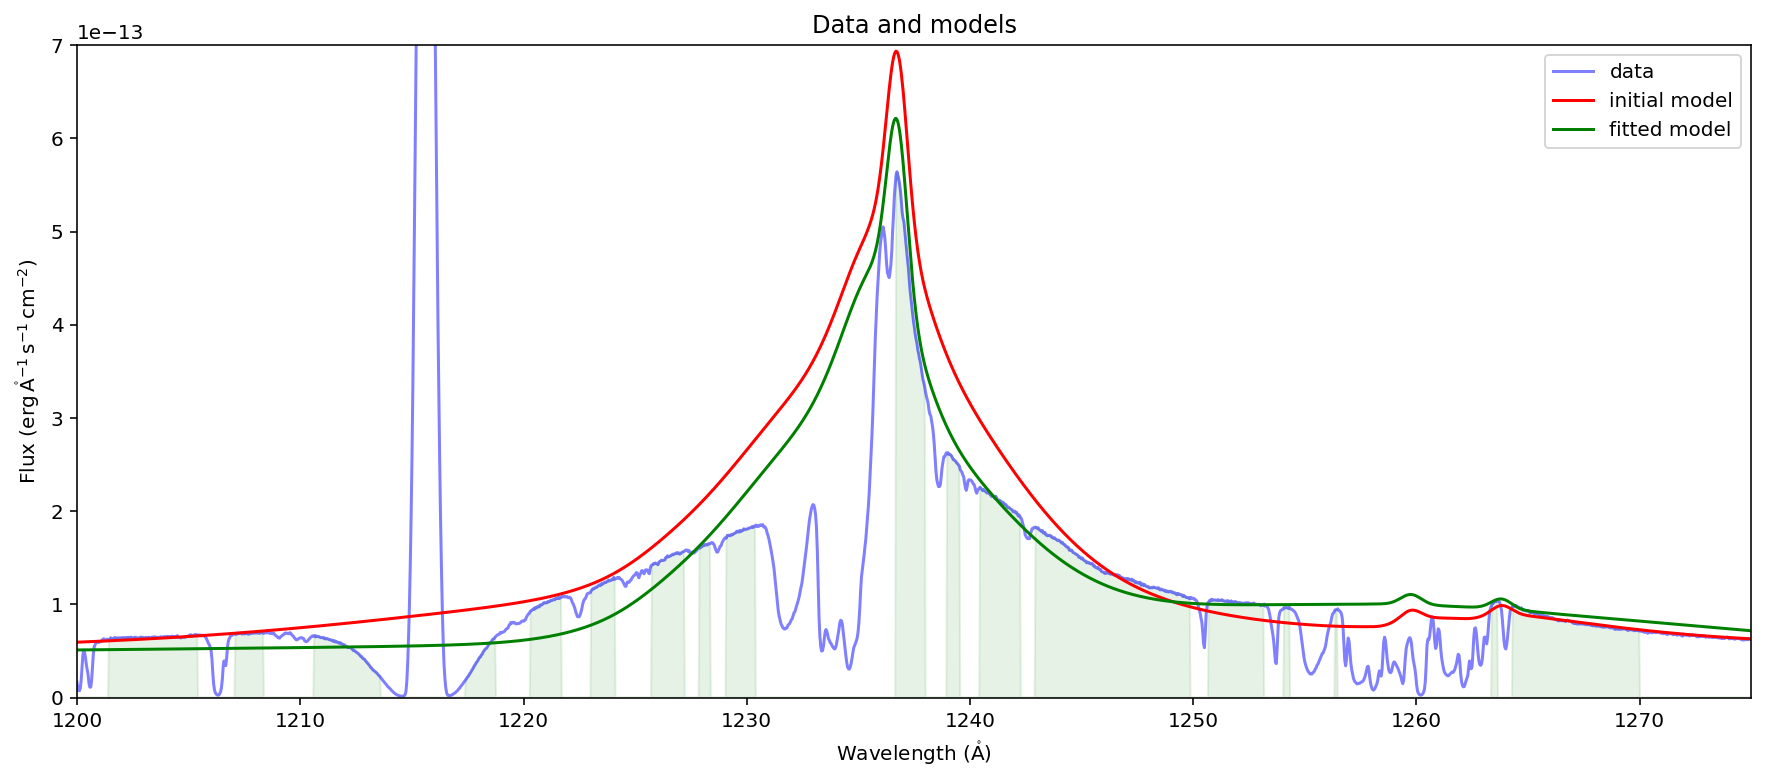

In [25]:
ax = plot_spectrum(spectrum,label='data')
ax.plot(wavelength, compound_model(wavelength), 'r',label='initial model')
ax.plot(wavelength, fit_result(wavelength), 'g',label='fitted model')
ax.set_xlim((1200,1275))
ax.set_ylim((0,7e-13))
ax.legend()
ax.set_title("Data and models");

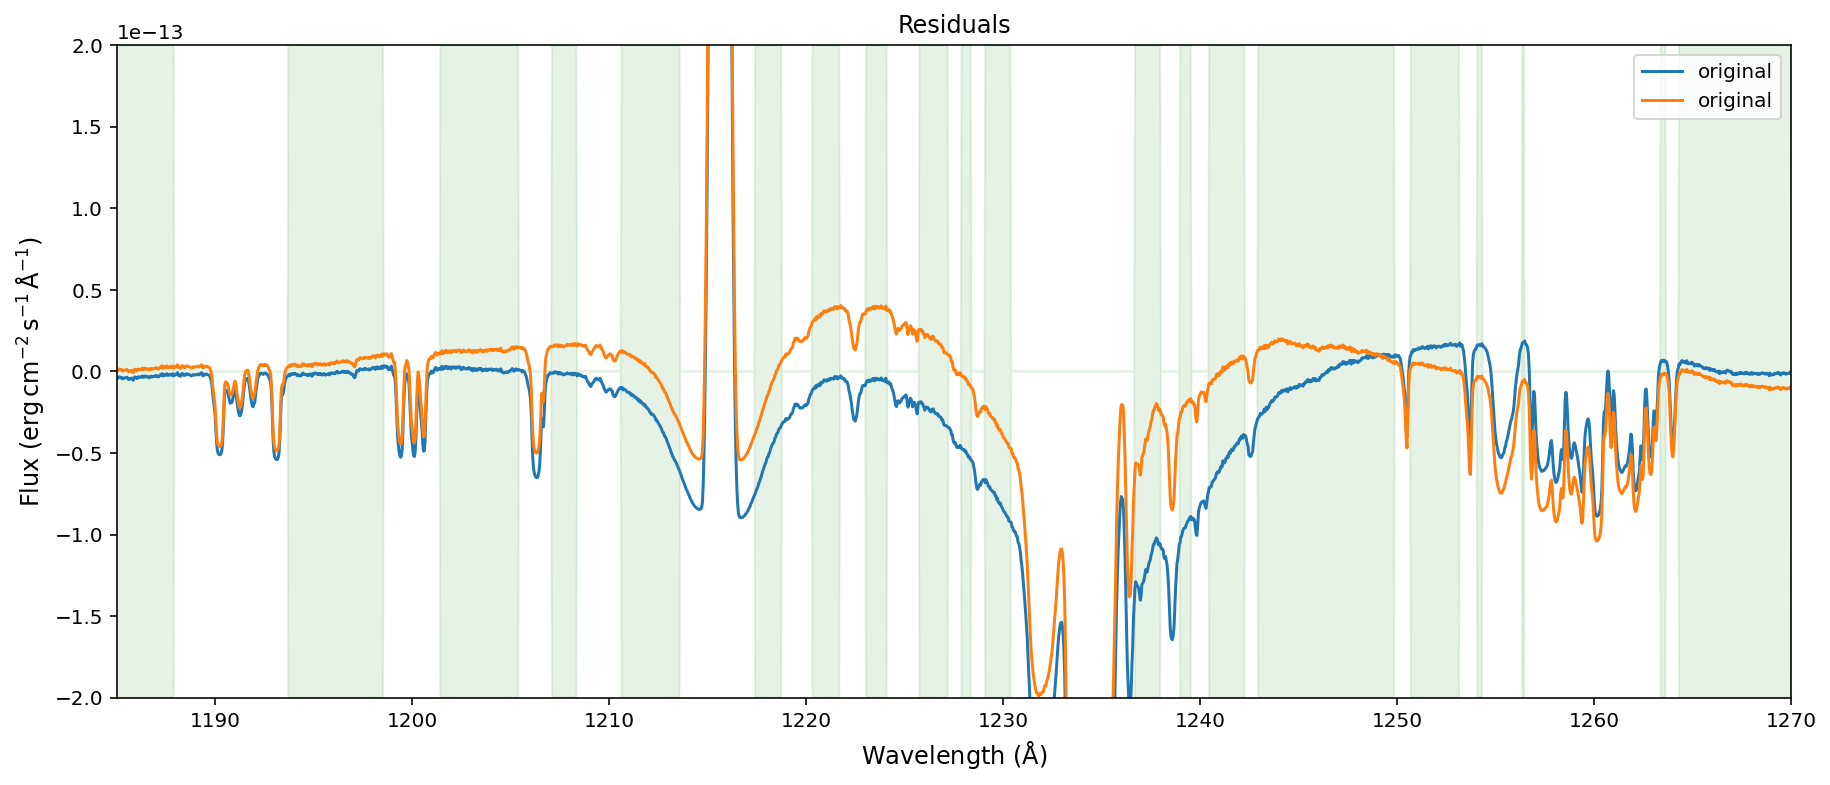

In [26]:
ylim = (-2.e-13, 2.e-13)
fig,ax = plt.subplots(figsize=(15,6))
ax.plot(wavelength,flux-compound_model(wavelength),label='original')
ax.plot(wavelength,flux-fit_result(wavelength),label='original')
ax.fill_between(wavelength,ylim[0]*spectrum.mask,ylim[1]*spectrum.mask,
                        alpha=0.1,color='g')
ax.set_xlim((1185., 1270.))
ax.set_ylim(ylim)
ax.legend()
ax.set_xlabel(r'Wavelength ($\rm \AA$)',fontsize='large')
ax.set_ylabel(r'Flux ($\rm erg\, cm^{-2}\, s^{-1}\, \AA^{-1}$)',fontsize='large')
ax.set_title('Residuals',fontsize='large');

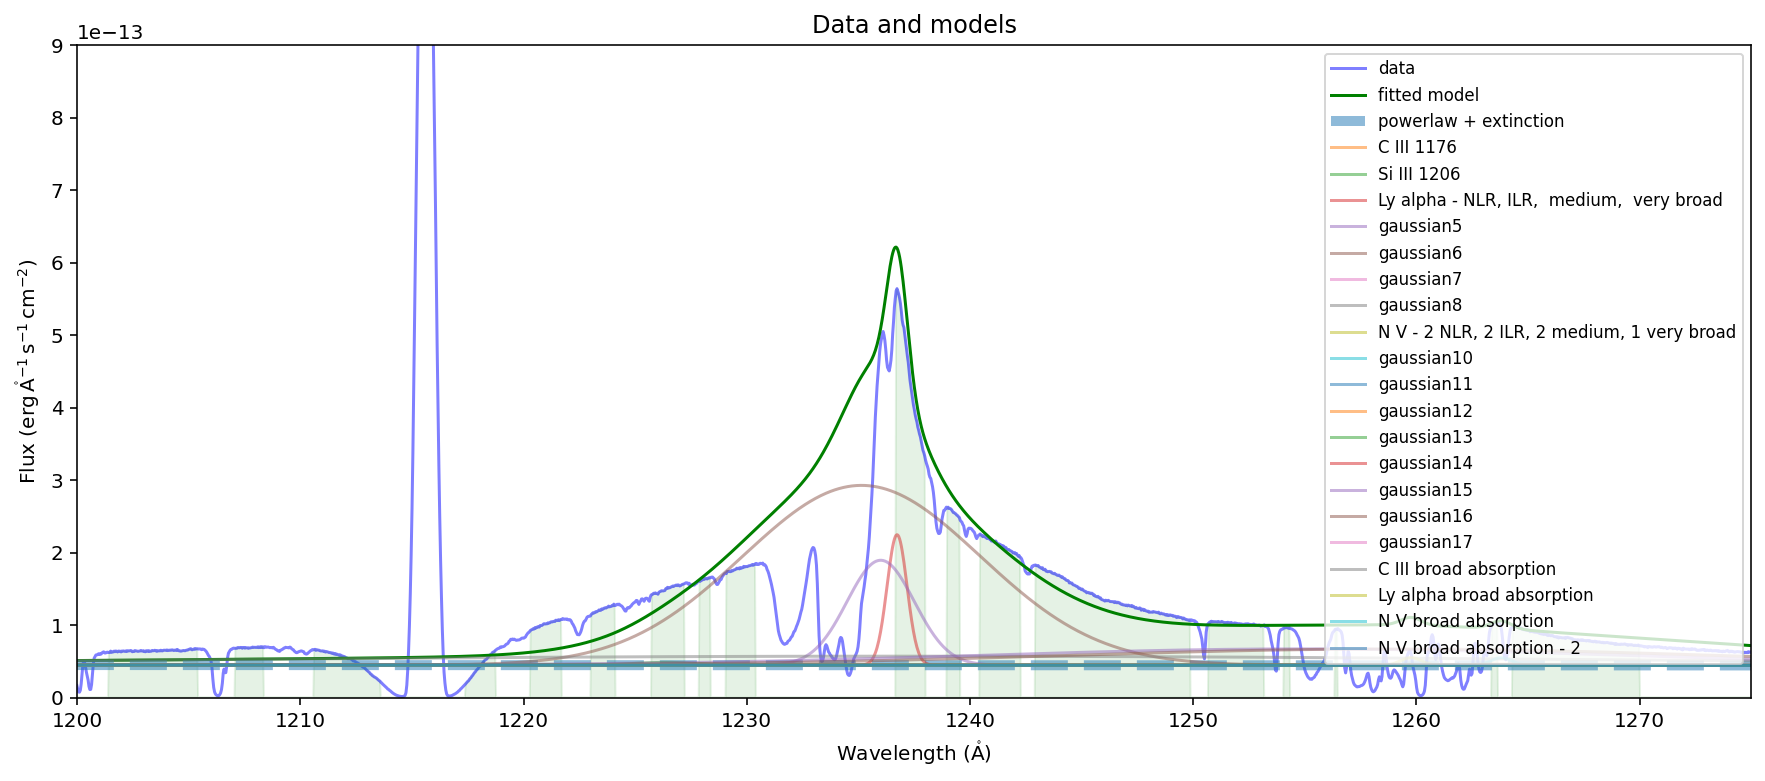

In [27]:
ax = plot_spectrum(spectrum,label='data')
ax.plot(wavelength, fit_result(wavelength), 'g',label='fitted model')
plext = fit_result['powerlaw1'] * fit_result['extinction']
ax.plot(wavelength,plext(wavelength),'--',alpha=0.5,linewidth=5,label="powerlaw + extinction")
for component in fit_result:
    if component.name != 'powerlaw1' and component.name != 'extinction':
        ax.plot(wavelength,(plext+component)(wavelength),label=component.name,alpha=0.5)
ax.set_xlim((1200,1275))
ax.set_ylim((0,9e-13))
ax.legend(loc='upper right',fontsize='small')
ax.set_title("Data and models");